<h1>03 模型训练<span class="tocSkip"></span></h1>

在应用特征和数据对模型进行训练时，需要结合评估指标来判断模型的有力。本赛题使用优惠券核销预测的平均AUC作为评价标准，即对每个优惠券ID（coupon_id）单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。因此，不能直接在验证集上使用**sklearn.metrics.roc_auc_score**，而要重新编写验证函数。

## 准备工作
### 引入代码包

In [1]:
import numpy as np  
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#########SKLearn 集成的算法###############
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
#########SKLearn 集成的算法###############
from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split # 切分数据
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error #评价指标

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### 全局参数

In [2]:
############全局参数#################################
id_col_names = ['user_id', 'coupon_id', 'date_received']
target_col_name = 'label'
id_target_cols = ['user_id', 'coupon_id', 'date_received', 'label']
myeval = 'roc_auc'
cvscore = 0
############目录定义#################################
datapath = '../data/'
featurepath = '../feature/'
resultpath = '../result/'
tmppath = '../tmp/'
scorepath = '../score/'

### 特征读取

In [3]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]


#返回Target列
def get_target_df(df):
    return df[target_col_name]


#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]


#按特征名读取训练集
def read_featurefile_train(featurename):
    df = pd.read_csv(featurepath + 'train_' + featurename + '.csv', sep=',', encoding="utf-8")
    df.fillna(0, inplace=True)
    return df


#按特征名读取测试集
def read_featurefile_test(featurename):
    df = pd.read_csv(featurepath + 'test_' + featurename + '.csv', sep=',', encoding="utf-8")
    df.fillna(0, inplace=True)
    return df


#按特征名读取数据
def read_data(featurename):
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf, testdf

### 模型训练代码

In [4]:
# 将特征归一化
def standize_df(train_data, test_data):
    from sklearn import preprocessing

    features_columns = [ f for f in test_data.columns if f not in id_target_cols]
    
    min_max_scaler = preprocessing.MinMaxScaler()

    train_data_scaler = min_max_scaler.fit_transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.fit_transform(test_data[features_columns])

    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns

    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns

    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler, test_data_scaler

In [5]:
####################部分整合在sklearn的分类算法###############
def get_sklearn_model(model_name):
    #朴素贝叶斯
    if model_name == 'NB':
        return MultinomialNB(alpha=0.01)
    #逻辑回归
    elif model_name == 'LR':
        return LogisticRegression(penalty='l2')
    # KNN
    elif model_name == 'KNN':
        return KNeighborsClassifier()
    #随机森林
    elif model_name == 'RF':
        return RandomForestClassifier()
    #决策树
    elif model_name == 'DT':
        return tree.DecisionTreeClassifier()
    #向量机
    elif model_name == 'SVC':
        return SVC(kernel='rbf')
    #GBDT
    elif model_name == 'GBDT':
        return GradientBoostingClassifier()
    #XGBoost
    elif model_name == 'XGB':
        return XGBClassifier()
    #lightGBM
    elif model_name == 'LGB':
        return LGBMClassifier()
    else:
        print("wrong model name!")


#画学习曲线
def plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=myeval,
        n_jobs=n_jobs,
        train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


#画算法的学习曲线,为加快画图速度，最多选20%数据
def plot_curve_single(traindf,
                      classifier,
                      cvnum,
                      train_sizes=[0.01, 0.02, 0.05, 0.1, 0.2, 0.3]):
    X = get_predictors_df(traindf)
    y = get_target_df(traindf)
    estimator = get_sklearn_model(classifier)  #建模
    title = "learning curve of " + classifier + ", cv:" + str(cvnum)
    plot_learning_curve(estimator,
                        title,
                        X,
                        y,
                        ylim=(0, 1.01),
                        cv=cvnum,
                        train_sizes=train_sizes)


#性能评价函数
#本赛题目标是预测投放的优惠券是否核销。
#针对此任务及一些相关背景知识，使用优惠券核销预测的平均AUC（ROC曲线下面积）作为评价标准。
#即对每个优惠券coupon_id单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。
# coupon平均auc计算
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        #测算AUC必须大于1个类别
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)


#按照日期分割
def test_model(traindf, classifier):
    train = traindf[traindf.date_received < 20160515].copy()
    test = traindf[traindf.date_received >= 20160515].copy()

    train_data = get_predictors_df(train).copy()
    train_target = get_target_df(train).copy()
    test_data = get_predictors_df(test).copy()
    test_target = get_target_df(test).copy()

    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:, 1]
    test['pred'] = result
    score = metrics.roc_auc_score(test_target, result)
    print(classifier + " 总体 AUC:", score)
    score_coupon = myauc(test)
    print(classifier + " Coupon AUC:", score_coupon)

#按训练数据集8:2分割
def test_model_split(traindf, classifier):

    target = get_target_df(traindf).copy()

    train_all, test_all, train_target, test_target = train_test_split(
        traindf, target, test_size=0.2, random_state=0)

    train_data = get_predictors_df(train_all).copy()
    test_data = get_predictors_df(test_all).copy()

    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result = clf.predict_proba(test_data)[:, 1]

    test = test_all.copy()
    test['pred'] = result

    score = metrics.roc_auc_score(test_target, result)
    print(classifier + "总体AUC:", score)
    score_coupon = myauc(test)
    print(classifier + " Coupon AUC:", score_coupon)

## 读取数据
所有特征都为上一节生成，因为会**使用KNN测试所以需要归一化**，是否缩放并不影响树模型

In [6]:
train_f1, test_f1 = read_data('f1')
train_f1, test_f1 = standize_df(train_f1, test_f1)

train_f2, test_f2 = read_data('sf2')
train_f2, test_f2 = standize_df(train_f2, test_f2)

#所有的特征都是上一节生成的
train_f3, test_f3 = read_data('sf3')
train_f3, test_f3 = standize_df(train_f3, test_f3)

In [7]:
train_f1.head()

,discount_rate,distance,if_fd,full_value,reduction_value,label,user_id,coupon_id,date_received
0,0.812785,0.1,1.0,0.500000,0.20,0,1439408,11002,20160528
1,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160613
2,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160516
3,0.761035,0.0,1.0,0.100000,0.05,0,2029232,1532,20160530
4,0.939117,0.0,1.0,0.066667,0.01,0,2029232,12737,20160519


In [8]:
print("特征f1数据框大小为%s"%str(train_f1.shape))
print("特征f1正样本数为%s"%str(train_f1.label.sum()))

特征f1数据框大小为(304509, 9)
特征f1正样本数为27878


In [9]:
train_f2.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,user_merchant_common_buy_rate,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0,4061024,9871,20160409


In [10]:
print("特征f2数据框大小为%s"%str(train_f2.shape))
print("特征f2正样本数为%s"%str(train_f2.label.sum()))

特征f2数据框大小为(438166, 41)
特征f2正样本数为33477


In [11]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0,4061024,9871,20160409


In [12]:
print("特征f3数据框大小为%s"%str(train_f3.shape))
print("特征f3正样本数为%s"%str(train_f3.label.sum()))

特征f3数据框大小为(438166, 49)
特征f3正样本数为33477


## 不同算法模型的性能对比

### 朴素贝叶斯

特征f1朴素贝叶斯成绩
NB 总体 AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647


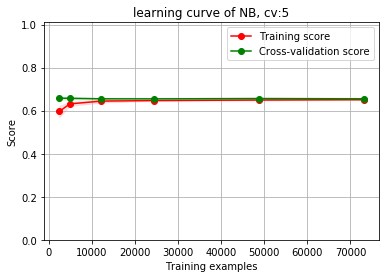

In [13]:
print("特征f1朴素贝叶斯成绩")
test_model(train_f1, 'NB')
plot_curve_single(train_f1, 'NB', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [14]:
print("特征f2朴素贝叶斯成绩")
test_model(train_f2, 'NB')
#使用特征f2朴素贝叶斯将结果都预测为一类，所以画不出图

特征f2朴素贝叶斯成绩
NB 总体 AUC: 0.7344423161179449
NB Coupon AUC: 0.6063348615415269


In [15]:
print("特征f3朴素贝叶斯成绩")
test_model(train_f3, 'NB')
#使用特征f3朴素贝叶斯将结果都预测为一类，所以画不出图

特征f3朴素贝叶斯成绩
NB 总体 AUC: 0.7757913474407871
NB Coupon AUC: 0.703026610226018


朴素贝叶斯算法的表现还可以，但成绩不是很好。在本赛题上，使用的是MultinomialNB，虽然MultinomialNB的参数比GaussianNB多，但是一共也只有三个。朴素贝叶斯算法优化的余地不大

### 逻辑回归

特征f1逻辑回归成绩
LR 总体 AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647


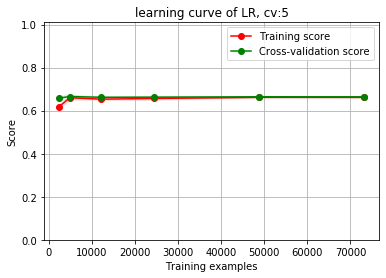

In [16]:
print("特征f1逻辑回归成绩")
test_model(train_f1, 'LR')
plot_curve_single(train_f1, 'LR', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

特征f2逻辑回归成绩
LR 总体 AUC: 0.7603254563229053
LR Coupon AUC: 0.6029319914741879


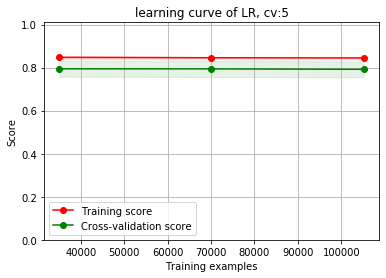

In [17]:
print("特征f2逻辑回归成绩")
test_model(train_f2, 'LR')
plot_curve_single(train_f2, 'LR', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

特征f3逻辑回归成绩
LR 总体 AUC: 0.8019624184861778
LR Coupon AUC: 0.7224643919684347


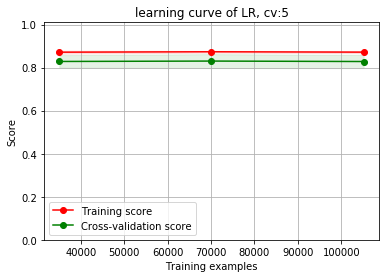

In [18]:
print("特征f3逻辑回归成绩")
test_model(train_f3, 'LR')
plot_curve_single(train_f3, 'LR', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

逻辑回归算法的表现很不错，但根据逻辑回归算法的特点，在本赛题上提升的空间也不大。在实际应用中，逻辑回归算法的应用广泛，因为消耗资源少。

### 决策树

特征f1决策树成绩
DT 总体 AUC: 0.6481609737147687
DT Coupon AUC: 0.5302514392404754


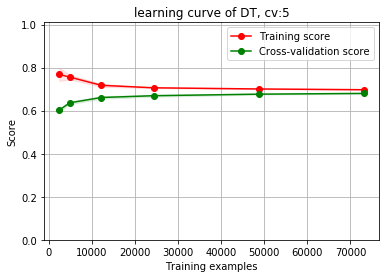

In [19]:
print("特征f1决策树成绩")
test_model(train_f1, 'DT')
plot_curve_single(train_f1, 'DT', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [20]:
print("特征f2决策树成绩")
test_model(train_f2, 'DT')

特征f2决策树成绩
DT 总体 AUC: 0.5251240014582413
DT Coupon AUC: 0.5198633841274759


In [21]:
print("特征f3决策树成绩")
test_model(train_f3, 'DT')

特征f3决策树成绩
DT 总体 AUC: 0.5713178860529703
DT Coupon AUC: 0.5722100012268947


决策树算法表现不好。决策树的**缺点是容易过拟合，忽略属性之间的相关性**。另外，决策树的**结果可能是不稳定**的，因为在数据中一个很小的变化就可能导致生成一个完全不同的树。这个问题可以**通过集成决策树来解决**。

### 随机森林

特征f1随机森林成绩
RF 总体 AUC: 0.6477964881940218
RF Coupon AUC: 0.5305377806545865


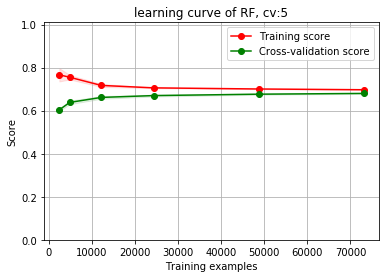

In [22]:
print("特征f1随机森林成绩")
test_model(train_f1, 'RF')
plot_curve_single(train_f1, 'RF', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [23]:
print("特征f2随机森林成绩")
test_model(train_f2, 'RF')

特征f2随机森林成绩
RF 总体 AUC: 0.6923338799890948
RF Coupon AUC: 0.5647086005119026


In [24]:
print("特征f3随机森林成绩")
test_model(train_f3, 'RF')

特征f3随机森林成绩
RF 总体 AUC: 0.7751155664549699
RF Coupon AUC: 0.7092944272623877


随机森林的结果比决策树算法略有提升。随机森林中的随机性主要体现在两个方面：<br/>
（1）随机采样：随机森林在计算每棵树时，都从全部训练样本（n）中选取一个可能有重复的、大小仍为n的数据集进行训练（即**booststrap采样**）<br/>
（2）特征选取的随机性：在每个节点随机选取所有特征的一个子集，用来计算最佳分割方法<br/>

### XGBoost

特征f1 XGBoost成绩
XGB 总体 AUC: 0.6556179120927842
XGB Coupon AUC: 0.5341814544847008


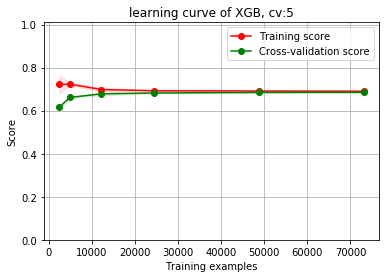

In [25]:
print("特征f1 XGBoost成绩")
test_model(train_f1, 'XGB')
plot_curve_single(train_f1, 'XGB', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [26]:
print("特征f2 XGBoost成绩")
test_model(train_f2, 'XGB')

特征f2 XGBoost成绩
XGB 总体 AUC: 0.7674808934510371
XGB Coupon AUC: 0.60209682661813


In [27]:
print("特征f3 XGBoost成绩")
test_model(train_f3, 'XGB')

特征f3 XGBoost成绩
XGB 总体 AUC: 0.82275203208879
XGB Coupon AUC: 0.7382430551948338


XGBoost算法表现不错，对于这一类问题，Boosting类的算法一般都不错。

### LightGBM

特征f1 LightGBM成绩
LGB 总体 AUC: 0.6531789464077291
LGB Coupon AUC: 0.5327458833266093


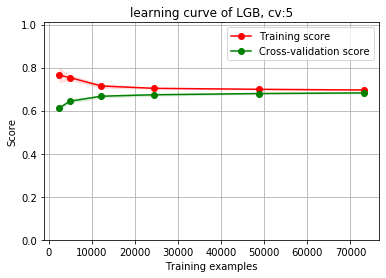

In [28]:
print("特征f1 LightGBM成绩")
test_model(train_f1, 'LGB')
plot_curve_single(train_f1, 'LGB', 5, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [29]:
print("特征f2 LightGBM成绩")
test_model(train_f2, 'LGB')

特征f2 LightGBM成绩
LGB 总体 AUC: 0.7677270455925923
LGB Coupon AUC: 0.5976219505359369


In [30]:
print("特征f3 LightGBM成绩")
test_model(train_f3, 'LGB')

特征f3 LightGBM成绩
LGB 总体 AUC: 0.8258363368655586
LGB Coupon AUC: 0.7375651718658945


LightGBM算法的表现最好。LightGBM具有训练效率高、使用内存低、支持并行化学习等特点。在处理不同问题时，LGB和XGB的成绩各有千秋，但LGB比XGB快得多。

### 结论
可以发现特征f2比特征f1的结果好很多，这是因为特征2使用滑窗方案，增加了很多统计特征。而特征3比特征又有了很大的提高，这是因为特征3增加了穿越特征。对比LightGBM和LR的成绩可以发现对于本问题，LightGBM有着更好的成绩。    

## 结果输出
通过分析发现特征sf3版本通过lightGBM分析的结果不错。下一步要做的事就是输出结果。

In [31]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,...,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,...,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,...,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,...,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,...,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,...,0.0,0,4061024,9871,20160409


In [32]:
#预测函数
def classifier_df_simple(train_feat, test_feat, classifier):
    model = get_sklearn_model(classifier)
    model.fit(get_predictors_df(train_feat), get_target_df(train_feat))
    predicted = pd.DataFrame(model.predict_proba(get_predictors_df(test_feat))[:, 1])
    return predicted


#输出结果函数
def output_predicted(predicted, resultfile, test_feat):
    predicted = round(predicted, 3)
    resultdf = get_id_df(test_feat).copy()
    resultdf['Probability'] = predicted
    return resultdf

In [33]:
predicted = classifier_df_simple(train_f3, test_f3, 'LGB')

In [34]:
predicted.head()

,0
0,0.048317
1,0.142236
2,0.007582
3,0.007582
4,0.030329


In [35]:
#生成结果数据
result = output_predicted(predicted, 'sf3_LGB.csv', test_f3)

In [36]:
result.head()

,user_id,coupon_id,date_received,Probability
0,4129537,9983,20160712,0.048
1,6949378,3429,20160706,0.142
2,2166529,6928,20160727,0.008
3,2166529,1808,20160727,0.008
4,6172162,6500,20160708,0.030


In [37]:
#输出结果
result.to_csv('sf3_lgb.csv', header=False, index=False, sep=',')

在代码目录下生成了sf3_lgb.csv，这个结果就可以提交了。